In [29]:
import numpy as np
import scipy
import matplotlib.pyplot as plt
import seaborn as sns

import torch
device = 'cpu'
from torchdiffeq import odeint

In [16]:
def FN_torch(t, V, a=0.2, b=0.2, c=3.0):
    return torch.hstack((c * (V[0] - V[0]**3/3 + V[1]), -1/c * (V[0] - a + b*V[1])))

def FN_torch_modified(t, V, eta, a=0.2, b=0.2, c=3.0):
    V1 = c * (V[0] - V[0]**3/3 + V[1])
    V2 = -1/c * (V[0] - a + b*V[1])
    dV = torch.hstack((V1, V2))
    terms = torch.tensor([V[0]**2, V[1]**2])
    dV += torch.matmul(eta, terms)
    return dV

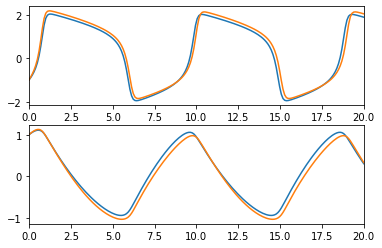

In [25]:
true_eta = torch.tensor([[0.3, 0], [0, 0.05]], dtype=torch.float)

fn_true = lambda t, x : FN_torch_modified(t, x, true_eta)

N = 200
ub = 20

t_space = torch.linspace(0, ub, N)
x0 = torch.tensor([-1.0, 1.0])
soln = odeint(fn_true, x0, t_space)

soln_unpert = odeint(FN_torch, x0, t_space)

ax1 = plt.subplot(211)
ax1.set_xlim(0,ub)
plt.plot(t_space, soln_unpert[:,0])
plt.plot(t_space, soln[:,0])

ax2 = plt.subplot(212, sharex=ax1)
plt.plot(t_space, soln_unpert[:,1])
plt.plot(t_space, soln[:,1])
plt.show()

In [40]:
class OptimizeFitzhugh(torch.nn.Module):
    
    def __init__(self, x0, t_space, n_terms, eta0):
        super(OptimizeFitzhugh, self).__init__()
        self.x0 = x0
        self.t_space = t_space
        self.n_terms = n_terms
        self.eta = eta0
        self.eta.requires_grad_()
        
    def rhs(self, x, t):
        return FN_torch_modified(t, x, self.eta)
    
    def forward(self, t, x):
        return self.rhs(x, t)

In [ ]:
eta_method = 'random'
check_grads = True
max_it = 100

N = 200
ub = 20

t_space = torch.linspace(0, ub, N)
x0 = torch.tensor([-1.0, 1.0])
x0.requires_grad_()
tol = 10**-5


if eta_method == 'random':
    eta0 = torch.tensor(np.random.normal(0, 0.001, (2,2)), dtype=torch.float).to(device)
elif eta_method == 'zeros':
    eta0 = torch.tensor(np.zeros((2,2)), dtype=torch.float).to(device)
elif eta_method == 'actual':
    eta0 = torch.tensor([[0.3, 0], [0, 0.05]], dtype=torch.float).to(device)
else:
    raise ValueError('You are trying to set eta in a way that is not supported. Check eta_method.')

print(eta0)

with torch.no_grad():
    true_eta = torch.tensor([[0.3, 0], [0, 0.05]], dtype=torch.float)
    true_FN = lambda t, x : FN_torch_modified(t, x, true_eta)
    true_soln = odeint(true_FN, x0, t_space)


optfitz = OptimizeFitzhugh(x0, t_space, 2, eta0).to(device)


optimizer = torch.optim.Adam([optfitz.eta], lr=10**-3)
loss = torch.nn.MSELoss().to(device)

print('eta_0 = \n{}\n'.format(optfitz.eta.detach().numpy()))

loss_vec = []
eta_log = []

np.set_printoptions(precision=4)
for it in range(max_it):

    optimizer.zero_grad()

    pred_soln = odeint(optfitz, x0, t_space).to(device)

    loss_curr = loss(pred_soln, true_soln)
    loss_curr.retain_grad()
    loss_curr.backward()

    if check_grads:
        if it > 0:
            for i in range(optfitz.eta.shape[0]):
                for j in range(optfitz.eta.shape[1]):
                    print('Backprop Derivative for {},{} = {:.2f}'.format(i, j, optfitz.eta.grad[i,j]))
                    print('Checked Derivative for {},{} = {:.2f}'.format(i, j, grad_check[i,j]))
                    # print('Error Ratio = {:.2f}'.format(optfitz.eta.grad[i,j] / grad_check[i,j]))
                    print()
        print('\n')

    print('Iterarion {}'.format(it+1))
    print('eta = \n{}'.format(optfitz.eta.detach().numpy()))
    eta_log.append(optfitz.eta.detach().numpy())
    print('loss = {:.2f}\n\n'.format(loss_curr))

    if np.linalg.norm(optfitz.eta.grad.detach().numpy()) < tol:
        if not (eta_method == 'actual' and it < 1):
            break

    loss_vec.append(loss_curr.detach().numpy())

    if check_grads:

        print('===Derivative Check===')

        grad_check = np.zeros((optfitz.eta.shape[0], optfitz.eta.shape[1]))
        for i in range(optfitz.eta.shape[0]):
            for j in range(optfitz.eta.shape[1]):
                eps = 10**(-3)
                eta_check_0 = optfitz.eta.detach().clone()
                eta_check_1 = optfitz.eta.detach().clone()

                eta_check_0[i,j] += eps
                eta_check_1[i,j] -= eps

                FN_check_0 = lambda t, S : FN_torch_modified(t, S, eta_check_0)
                x_pred_check_0 = odeint(FN_check_0, x0, t_space)
                FN_check_1 = lambda t, S : FN_torch_modified(t, S, eta_check_1)
                x_pred_check_1 = odeint(FN_check_1, x0, t_space)

                L0 = loss(x_pred_check_0, true_soln)
                L1 = loss(x_pred_check_1, true_soln)
                grad_check[i,j] = ((L0 - L1)/(2*eps)).item()

    optimizer.step()


tensor([[-0.0014, -0.0003],
        [ 0.0003,  0.0014]])
eta_0 = 
[[-0.00137111 -0.00033837]
 [ 0.00028917  0.00144796]]



Iterarion 1
eta = 
[[-0.0014 -0.0003]
 [ 0.0003  0.0014]]
loss = 0.03


===Derivative Check===
Backprop Derivative for 0,0 = 0.04
Checked Derivative for 0,0 = 0.06

Backprop Derivative for 0,1 = -0.04
Checked Derivative for 0,1 = -0.04

Backprop Derivative for 1,0 = -4.85
Checked Derivative for 1,0 = -5.94

Backprop Derivative for 1,1 = -0.82
Checked Derivative for 1,1 = -1.02



Iterarion 2
eta = 
[[-0.0024  0.0007]
 [ 0.0013  0.0024]]
loss = 0.02


===Derivative Check===
Backprop Derivative for 0,0 = 0.02
Checked Derivative for 0,0 = 0.04

Backprop Derivative for 0,1 = -0.03
Checked Derivative for 0,1 = -0.04

Backprop Derivative for 1,0 = -3.64
Checked Derivative for 1,0 = -4.85

Backprop Derivative for 1,1 = -0.61
Checked Derivative for 1,1 = -0.83



Iterarion 3
eta = 
[[-0.0033  0.0017]
 [ 0.0023  0.0034]]
loss = 0.02


===Derivative Check===
Backprop Deriva

Backprop Derivative for 0,0 = -0.03
Checked Derivative for 0,0 = -0.04

Backprop Derivative for 0,1 = -0.02
Checked Derivative for 0,1 = -0.03

Backprop Derivative for 1,0 = -1.50
Checked Derivative for 1,0 = -1.56

Backprop Derivative for 1,1 = -0.24
Checked Derivative for 1,1 = -0.25



Iterarion 23
eta = 
[[0.0083 0.0153]
 [0.0041 0.0045]]
loss = 0.01


===Derivative Check===
Backprop Derivative for 0,0 = -0.03
Checked Derivative for 0,0 = -0.04

Backprop Derivative for 0,1 = -0.02
Checked Derivative for 0,1 = -0.03

Backprop Derivative for 1,0 = -1.40
Checked Derivative for 1,0 = -1.55

Backprop Derivative for 1,1 = -0.22
Checked Derivative for 1,1 = -0.25



Iterarion 24
eta = 
[[0.0091 0.0161]
 [0.0042 0.0046]]
loss = 0.01


===Derivative Check===
Backprop Derivative for 0,0 = -0.03
Checked Derivative for 0,0 = -0.04

Backprop Derivative for 0,1 = -0.02
Checked Derivative for 0,1 = -0.02

Backprop Derivative for 1,0 = -1.22
Checked Derivative for 1,0 = -1.45

Backprop Derivative 

Backprop Derivative for 0,0 = -0.05
Checked Derivative for 0,0 = -0.05

Backprop Derivative for 0,1 = -0.02
Checked Derivative for 0,1 = -0.02

Backprop Derivative for 1,0 = -0.51
Checked Derivative for 1,0 = -0.53

Backprop Derivative for 1,1 = -0.07
Checked Derivative for 1,1 = -0.07



Iterarion 45
eta = 
[[0.0256 0.0321]
 [0.0051 0.0041]]
loss = 0.01


===Derivative Check===
Backprop Derivative for 0,0 = -0.05
Checked Derivative for 0,0 = -0.05

Backprop Derivative for 0,1 = -0.02
Checked Derivative for 0,1 = -0.02

Backprop Derivative for 1,0 = -0.49
Checked Derivative for 1,0 = -0.55

Backprop Derivative for 1,1 = -0.06
Checked Derivative for 1,1 = -0.07



Iterarion 46
eta = 
[[0.0264 0.0328]
 [0.0051 0.004 ]]
loss = 0.01


===Derivative Check===
Backprop Derivative for 0,0 = -0.05
Checked Derivative for 0,0 = -0.05

Backprop Derivative for 0,1 = -0.02
Checked Derivative for 0,1 = -0.02

Backprop Derivative for 1,0 = -0.43
Checked Derivative for 1,0 = -0.53

Backprop Derivative 

Backprop Derivative for 0,0 = -0.05
Checked Derivative for 0,0 = -0.06

Backprop Derivative for 0,1 = -0.01
Checked Derivative for 0,1 = -0.01

Backprop Derivative for 1,0 = -0.17
Checked Derivative for 1,0 = -0.23

Backprop Derivative for 1,1 = -0.01
Checked Derivative for 1,1 = -0.02



Iterarion 67
eta = 
[[0.0435 0.0481]
 [0.0057 0.0028]]
loss = 0.01


===Derivative Check===
Backprop Derivative for 0,0 = -0.05
Checked Derivative for 0,0 = -0.06

Backprop Derivative for 0,1 = -0.01
Checked Derivative for 0,1 = -0.01

Backprop Derivative for 1,0 = -0.13
Checked Derivative for 1,0 = -0.21

Backprop Derivative for 1,1 = -0.00
Checked Derivative for 1,1 = -0.01



Iterarion 68
eta = 
[[0.0443 0.0488]
 [0.0057 0.0028]]
loss = 0.01


===Derivative Check===
Backprop Derivative for 0,0 = -0.05
Checked Derivative for 0,0 = -0.06

Backprop Derivative for 0,1 = -0.01
Checked Derivative for 0,1 = -0.01

Backprop Derivative for 1,0 = -0.09
Checked Derivative for 1,0 = -0.17

Backprop Derivative 

Backprop Derivative for 0,0 = -0.05
Checked Derivative for 0,0 = -0.05

Backprop Derivative for 0,1 = -0.01
Checked Derivative for 0,1 = -0.01

Backprop Derivative for 1,0 = -0.01
Checked Derivative for 1,0 = -0.06

Backprop Derivative for 1,1 = 0.02
Checked Derivative for 1,1 = 0.01



Iterarion 89
eta = 
[[0.061  0.0627]
 [0.006  0.0013]]
loss = 0.01


===Derivative Check===
Backprop Derivative for 0,0 = -0.05
Checked Derivative for 0,0 = -0.05

Backprop Derivative for 0,1 = -0.01
Checked Derivative for 0,1 = -0.01

Backprop Derivative for 1,0 = 0.01
Checked Derivative for 1,0 = -0.04

Backprop Derivative for 1,1 = 0.02
Checked Derivative for 1,1 = 0.01



Iterarion 90
eta = 
[[0.0618 0.0634]
 [0.006  0.0012]]
loss = 0.01


===Derivative Check===
Backprop Derivative for 0,0 = -0.05
Checked Derivative for 0,0 = -0.05

Backprop Derivative for 0,1 = -0.01
Checked Derivative for 0,1 = -0.01

Backprop Derivative for 1,0 = 0.02
Checked Derivative for 1,0 = -0.02

Backprop Derivative for 1,

In [ ]:
fig, ax = plt.subplots(1,1)
ax.plot(range(len(loss_vec)), loss_vec)
ax.set_xlabel('Iterations')
ax.set_ylabel('MSE Loss')
ax.set_title('Loss as a Function of Iterations')
ax.set_xlim((0, max_it))
ax.set_ylim((0, max(loss_vec) + 10))
plt.grid()
plt.show()